### Week 7: Performance Evaluations
###### Joel Konitzer
###### 10/08/2022

In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

import EDAFunctions

import PerformanceMetrics
import CARTFunctions

In [13]:
df = pd.read_csv('bank-full.csv', sep=';')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [15]:
df.shape

(45211, 17)

In [16]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [17]:
df_transformed, encoder, colsCat, colsNum = CARTFunctions.transform_categoricals(df.copy())

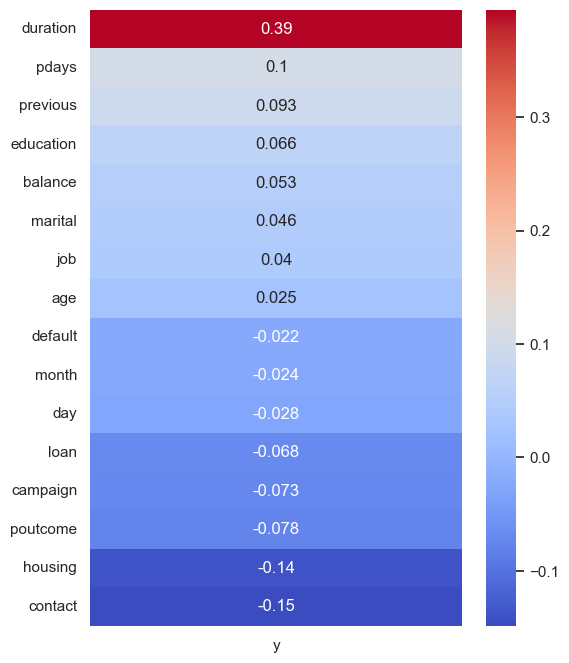

In [18]:
EDAFunctions.corr_to_target(df_transformed, 'y', title=None, file=None)

In [19]:
#Divide age by duration to score financial maturity
df_transformed['maturity'] = np.round(df_transformed.age / df_transformed.duration, decimals = 3)
#Consolidate time references 
df_transformed['recent_contract'] = df_transformed.month * df_transformed.day
#Identify stagnate or mature customers
df_transformed['cooldown'] = np.round(df_transformed.balance / df_transformed.duration, decimals = 3)

#Drop redundent columns
cols = ['duration','balance','day','month']
df_transformed = df_transformed.drop(cols, axis=1)

In [20]:
#Drop any unwanted datatypes from previous transformations
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "data is not dataframe"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
df_transformed = clean_dataset(df_transformed)

Create multiple train & test sets for model evaluation

In [21]:
x_train, x_test, y_train, y_test = CARTFunctions.train_test(df_transformed, 'y')

In [22]:
x_train_norm, x_test_norm = CARTFunctions.norm(x_train, x_test, colsNum)

In [23]:
x_train_scale, x_test_scale = CARTFunctions.scale(x_train, x_test, colsNum)

In [125]:
#Prepared dataframe
df_transformed.head()

,age,job,marital,education,default,housing,loan,contact,campaign,pdays,previous,poutcome,y,maturity,recent_contract,cooldown
0,58.0,4.0,1.0,2.0,0.0,1.0,0.0,2.0,1.0,-1.0,0.0,3.0,0.0,0.222,40.0,8.211
1,44.0,9.0,2.0,1.0,0.0,1.0,0.0,2.0,1.0,-1.0,0.0,3.0,0.0,0.291,40.0,0.192
2,33.0,2.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,-1.0,0.0,3.0,0.0,0.434,40.0,0.026
3,47.0,1.0,1.0,3.0,0.0,1.0,0.0,2.0,1.0,-1.0,0.0,3.0,0.0,0.511,40.0,16.370
4,33.0,11.0,2.0,3.0,0.0,0.0,0.0,2.0,1.0,-1.0,0.0,3.0,0.0,0.167,40.0,0.005


#### Model development

##### i. Random Forest

In [25]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.ensemble import RandomForestClassifier

#Additional hyperparameters to demonstrate gridsearch
param_grid = [
    {'criterion': ['gini','entropy','log_loss'],'max_features': ['auto','sqrt','log2']}
]

rf = RandomForestClassifier(n_jobs = -1, random_state=41)
cv = RepeatedKFold(n_splits = 10, n_repeats = 10, random_state=41)

#GridSearchCV scoring using ROC_AUC since this is of interest for this exercise
search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring="roc_auc", cv=cv)
#Using the normalized training set
search.fit(x_train_scale, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=10, random_state=41),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=41),
             param_grid=[{'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_features': ['auto', 'sqrt', 'log2']}],
             scoring='roc_auc')

In [27]:
#View gridsearchCV results to find optimal hyperparameters 
results_df = pd.DataFrame(search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
entropy_auto,"{'criterion': 'entropy', 'max_features': 'auto'}",1,0.910843,0.006263
entropy_sqrt,"{'criterion': 'entropy', 'max_features': 'sqrt'}",1,0.910843,0.006263
entropy_log2,"{'criterion': 'entropy', 'max_features': 'log2'}",1,0.910843,0.006263
log_loss_auto,"{'criterion': 'log_loss', 'max_features': 'auto'}",1,0.910843,0.006263
log_loss_sqrt,"{'criterion': 'log_loss', 'max_features': 'sqrt'}",1,0.910843,0.006263
log_loss_log2,"{'criterion': 'log_loss', 'max_features': 'log2'}",1,0.910843,0.006263
gini_auto,"{'criterion': 'gini', 'max_features': 'auto'}",7,0.909385,0.006692
gini_sqrt,"{'criterion': 'gini', 'max_features': 'sqrt'}",7,0.909385,0.006692
gini_log2,"{'criterion': 'gini', 'max_features': 'log2'}",7,0.909385,0.006692


In [46]:
#View features by importance from optimal RF configuration
from sklearn.ensemble import RandomForestClassifier

#Create RF model using optimal hyper parameters 
rf_model = RandomForestClassifier(criterion='entropy',max_features='sqrt',n_jobs = -1, random_state=41)
rf_model.fit(x_train_scale,y_train)
rf_pred = rf_model.predict(x_test_scale) 

#Drop target column from feautre column set
feature_cols = df_transformed.drop('y',axis=1).columns
#Use scikitlearn feature_importances_ 
importance_list = list(zip(feature_cols,rf_model.feature_importances_))
sorted_import_feature = sorted(importance_list, key = lambda x: x[1],reverse=True)
#Generate ordered list of features by importance
max_feature_len = len(max(feature_cols, key=len))
for feature, rank in sorted_import_feature:
    dots = max_feature_len - len(feature)
    print(f'{feature}: {"."*dots} {rank*100:.2f}%')

maturity: ....... 29.31%
cooldown: ....... 12.53%
recent_contract:  11.81%
age: ............ 11.71%
job: ............ 5.21%
poutcome: ....... 4.95%
pdays: .......... 4.79%
campaign: ....... 4.40%
contact: ........ 3.23%
housing: ........ 3.03%
education: ...... 2.89%
previous: ....... 2.49%
marital: ........ 2.28%
loan: ........... 1.17%
default: ........ 0.18%


##### ii. KNN

Evaluating 1 clusters
Score 0.828
Evaluating 2 clusters
Score 0.872
Evaluating 3 clusters
Score 0.860
Evaluating 4 clusters
Score 0.879
Evaluating 5 clusters
Score 0.872


Text(0, 0.5, 'Score')

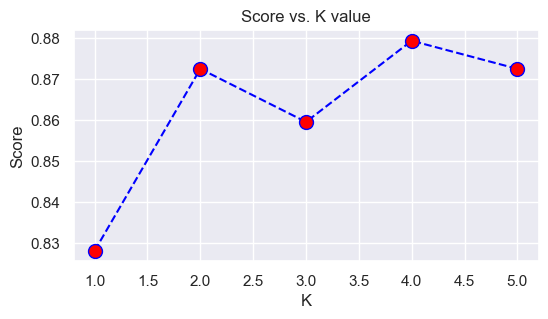

In [73]:
from sklearn.neighbors import KNeighborsClassifier
#Loop through max 6 nearest neighbors to identify optimal k by 
#Scored by mean accuracy on test dataset
scores = []
for k in range(1, 6):
    #Print cluser score
    print(f'Evaluating {k} clusters')
    knn_model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn_model.fit(x_train_scale, y_train)
    scores.append(knn_model.score(x_test_scale, y_test))
    print('Score {:.3f}'.format(knn_model.score(x_test_scale, y_test)))
    
#View elbow plot
plt.figure(figsize=(6,3))
plt.plot(range(1,6),scores,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Score vs. K value')
plt.xlabel('K')
plt.ylabel('Score')

In [141]:
#Get optimal k
opt_K_S = scores.index(max(scores)) + 1

#Create KNN model using optimal k from previous step
model_knn = KNeighborsClassifier(n_neighbors=opt_K_S, n_jobs=-1)
model_knn.fit(x_train_scale, y_train)
knn_pred = model_knn.predict(x_test_scale)             

##### iii. SVM

In [71]:
#Create SVM model default parameters. 
from sklearn.svm import SVC

svm_model = SVC(kernel = 'rbf', random_state= 42, probability=True)
svm_model.fit(x_train_scale, y_train)
#Set prediction var
svm_pred = svm_model.predict(x_test_scale)

#### Performance evaluation & comparison

In [34]:
#Performance metric functions
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [79]:
print(classification_report(y_test,rf_pred))
print("=======================================================")
_rf ,precision_test_rf, recall_test_rf, f1_test_rf, accuracy_rf = PerformanceMetrics.eval_model_test(rf_model, x_test_scale, y_test)
print("RF test set performance metrics:")
print("Precision = {:.3f} \nRecall = {:.3f} \nf1 = {:.3f} \nAUC ROC = {:.3f}".format(precision_test_rf, recall_test_rf, f1_test_rf, accuracy_rf))
_rf ,precision_train_rf, recall_train_rf, f1_train_rf, accuracy_train_rf = PerformanceMetrics.eval_model_train(rf_model, x_train_scale, y_train)
print("_______________________________________________________")
print("RF train set performance metrics:")
print("Precision = {:.3f} \nRecall = {:.3f} \nf1 = {:.3f} \nAUC ROC = {:.3f}".format(precision_train_rf, recall_train_rf, f1_train_rf, accuracy_train_rf))

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94      7964
         1.0       0.61      0.36      0.45      1078

    accuracy                           0.90      9042
   macro avg       0.77      0.66      0.70      9042
weighted avg       0.88      0.90      0.88      9042

RF test set performance metrics:
Precision = 0.614 
Recall = 0.356 
f1 = 0.451 
AUC ROC = 0.904
_______________________________________________________
RF train set performance metrics:
Precision = 1.000 
Recall = 1.000 
f1 = 1.000 
AUC ROC = 1.000


In [78]:
print(classification_report(y_test,knn_pred), '\n')
print("=======================================================")
_knn , precision_test_knn, recall_test_knn, f1_test_knn, accuracy_knn = PerformanceMetrics.eval_model_test(knn_model, x_test_scale, y_test)
print("KNN test set performance metrics:")
print("Precision = {:.3f} \nRecall = {:.3f} \nf1 = {:.3f} \nAUC ROC = {:.3f}".format(precision_test_knn, recall_test_knn, f1_test_knn, accuracy_knn))
_knn , precision_train_knn, recall_train_knn, f1_train_knn, accuracy_train_knn = PerformanceMetrics.eval_model_train(knn_model, x_train_scale, y_train)
print("_______________________________________________________")
print("KNN train set performance metrics:")
print("Precision = {:.3f} \nRecall = {:.3f} \nf1 = {:.3f} \nAUC ROC = {:.3f}".format(precision_train_knn, recall_train_knn, f1_train_knn, accuracy_train_knn))

              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93      7964
         1.0       0.48      0.15      0.23      1078

    accuracy                           0.88      9042
   macro avg       0.69      0.56      0.58      9042
weighted avg       0.85      0.88      0.85      9042
 

KNN test set performance metrics:
Precision = 0.428 
Recall = 0.206 
f1 = 0.278 
AUC ROC = 0.690
_______________________________________________________
KNN train set performance metrics:
Precision = 0.701 
Recall = 0.308 
f1 = 0.428 
AUC ROC = 0.916


In [72]:
print("Classification report, normalized test set:")
print(classification_report(y_test, svm_pred))
print("=======================================================")
_svm , precision_test_svm, recall_test_svm, f1_test_svm, accuracy_svm = PerformanceMetrics.eval_model_test(svm_model, x_test, y_test)
print("SVM test set performance metrics:")
print("Precision = {:.3f} \nRecall = {:.3f} \nf1 = {:.3f} \nAUC ROC = {:.3f}".format(precision_test_svm, recall_test_svm, f1_test_svm, accuracy_svm))
_svm , precision_train_svm, recall_train_svm, f1_train_svm, accuracy_train_svm = PerformanceMetrics.eval_model_train(svm_model, x_train, y_train)
print("_______________________________________________________")
print("SVM train set performance metrics:")
print("Precision = {:.3f} \nRecall = {:.3f} \nf1 = {:.3f} \nAUC ROC = {:.3f}".format(precision_train_svm, recall_train_svm, f1_train_svm, accuracy_train_svm))

Classification report, normalized test set:
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      7964
         1.0       0.60      0.00      0.01      1078

    accuracy                           0.88      9042
   macro avg       0.74      0.50      0.47      9042
weighted avg       0.85      0.88      0.83      9042

SVM test set performance metrics:
Precision = 0.333 
Recall = 0.001 
f1 = 0.002 
AUC ROC = 0.622
_______________________________________________________
SVM train set performance metrics:
Precision = 0.571 
Recall = 0.002 
f1 = 0.004 
AUC ROC = 0.629


Random forest AUC: 0.663
Constant AUC:  0.5
Optimal threshold:  0.17


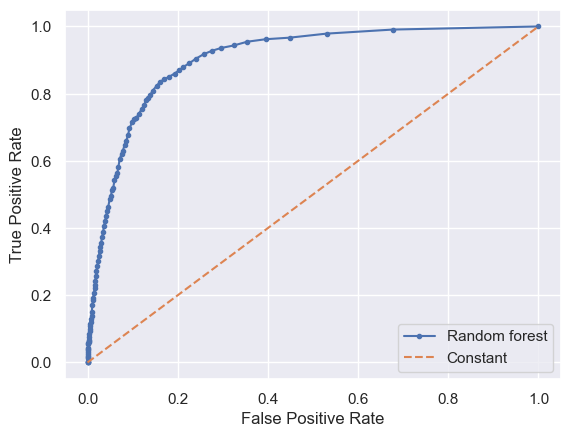

In [140]:
from matplotlib import pyplot
#Generate constant range
ns_probs = [0 for _ in range(len(y_test))]
#Get thresholds from rf model
thresholds_prob = rf_model.predict_proba(x_test_scale)[:,1]
#Set roc curve
fpr, tpr, thresholds = roc_curve(y_test, thresholds_prob)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

#Calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
rf_auc = roc_auc_score(y_test, rf_pred)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
pyplot.plot(fpr, tpr, marker='.', label='Random forest')
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Constant')

print('Random forest AUC: {:.3f}'.format(rf_auc))
print('Constant AUC: ', ns_auc)
print('Optimal threshold: ', optimal_threshold)

#Axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
#Show the legend
pyplot.legend()
#Show the plot
pyplot.show()

##### Analysis of results

###### This analysis demonstrates model performance evaluation using various data science concepts and originates from marketing campaigns of a Portuguese banking institution. The models created were Random Forest, K- Nearest Neighbor, and Support Vector Machine. Data preparation included converting the categorical values to numeric and feature reduction to eliminate multicollinearity. Both standardized and normalized train and test sets were created and trained. 
###### The results of the test sets showed bias to the training sets. For example, for the KNN model, the test set AUC ROC is 0.69 while the train set AUC ROC is 0.91. The same results are seen in the other models, with the Random Forest having the highest AUC ROC of 1, which may have resulted from over-cross-validating the training set since that high value is not seen in other model evaluations. The random forest model ultimately showed this analysis's best test set performance. The threshold that was found to be optimal was 0.17,  taking the true positives and subtracting the false positives. For the case of the marketing data, the intention would be the retain customers - false positives would be highly discouraged. Because the data is imbalanced, the model does not perform optimally with new data, so further efforts should be explored, including alternative cross-validation methods and model optimization.
